<a href="https://colab.research.google.com/github/Crome4975/Higgs-Dimensionality-Reduction/blob/main/PURSUEHiggs_DimReduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Data obtention and preparation**

Download the Higgs data from UC Irvine repository

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!wget -O HIGGS2.csv.gz https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz

Mounted at /content/gdrive
--2023-08-25 06:30:30--  https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘HIGGS2.csv.gz’

HIGGS2.csv.gz           [          <=>       ]   2.62G  8.27MB/s    in 4m 50s  

2023-08-25 06:35:21 (9.28 MB/s) - ‘HIGGS2.csv.gz’ saved [2816407858]



Unzip the data

In [2]:
 !gzip -f -d HIGGS2.csv.gz

Import packages

In [3]:
import os
import sys
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pandas as pd
import numpy as np
np.random.seed(42)  # for reproducibility
import matplotlib.pyplot as plt

Load the data

In [4]:
data = pd.read_csv('./HIGGS2.csv')

### **Select between all features or low-level features only**

In [5]:
n_features = input("Please write 29 for all features and 22 for low-level features only: ")
n_features = int(n_features)

Please write 29 for all features and 22 for low-level features only: 22


Separate labels (y) from inputs (X)

In [6]:
X = data.iloc[:,1:n_features]
y = data.iloc[:,0]
print(X.shape)

(10999999, 21)


Select size of dataset

In [7]:
X = X[:2500000]
y = y[:2500000]

### **Select which features to drop**


The first 21 features are low-level, and the last 7 are high-level, in the following order:

names = ["lepton pT", "lepton eta", "lepton phi", "missing energy magnitude",
"missing energy phi", "jet 1 pt", "jet 1 eta", "jet 1 phi", "jet 1 b-tag",
"jet 2 pt", "jet 2 eta","jet 2 phi", "jet 2 b-tag", "jet 3 pt", "jet 3 eta",
"jet 3 phi", "jet 3 b-tag", "jet 4 pt", "jet 4 eta", "jet 4 phi", "jet 4 b-tag",
"m_jj", "m_jjj", "m_lv", "m_jlv", "m_bb", "m_wbb", "m_wwbb"]

If we were to drop the b-tags from the jets 2 and 4, we would do the following:

In [8]:
X = X.drop(X.columns[[12, 20]], axis=1)

Please adjust the previous code to the features you would like to remove

### **Select between PCA and Autoencoder**



In [9]:
method = input("Please write Autoencoder or PCA: ")

Please write Autoencoder or PCA: None


### **Select expected dimensions**

In [10]:
latent_dim = input("Please select the expected dimensions (<28): ")
latent_dim = int(latent_dim)

Please select the expected dimensions (<28): 19


### **Perform dimensionality reduction with selected method**

In [11]:
if method == "Autoencoder":
  np.random.seed(42)
  tf.random.set_seed(42)
  #Create training, validation, and test datasets

  X_train, X_val1, y_train, y_val1 = train_test_split(X, y, test_size=0.2, random_state=42)
  X_val, X_test, y_val, y_test = train_test_split(X_val1, y_val1, test_size=0.5, random_state=42)
  del X
  del y
  del X_val1
  del y_val1

  # Dimension of dataset
  original_dimension = X_train.shape[1]

  #Encoder component

  encoder = keras.models.Sequential(
      [
      keras.layers.Dense(128, input_shape=(original_dimension,), activation= 'relu'),
      keras.layers.Dense(128, activation= 'relu'),
      keras.layers.Dense(latent_dim, name= 'encoding_layer') #Encoding Layer
      ]
  )

  #Decoder Component

  decoder = keras.models.Sequential(
      [
      keras.layers.Dense(128, name= '3rd_hidden_layer', input_shape=(latent_dim,), activation= 'relu'),
      keras.layers.Dense(128, activation= 'relu'),
      keras.layers.Dense(original_dimension, name= 'output_layer')
      ]
  )

  #Create autoencoder

  encoder_decoder_model= keras.Model(
      inputs = encoder.inputs,
      outputs = decoder(encoder.outputs)
  )
  #Compiling the model

  encoder_decoder_model.compile(
      loss= 'mse',
      optimizer= 'adam',
      metrics= 'mse'
  )
  # Train the autoencoder

  model_history= encoder_decoder_model.fit(X_train[y_train==1], X_train[y_train==1], validation_data=(X_val[y_val==1],X_val[y_val==1]),epochs = 50, batch_size = 128)

  #Generate codings

  codings_train = encoder.predict(X_train)
  codings_valid = encoder.predict(X_val)
  codings_test = encoder.predict(X_test)
  print(codings_train.shape)
  print(codings_valid.shape)
  print(codings_test.shape)

  #Save the encoder

  encoder.save('encoder_name.h5')

elif method == "PCA":

  #Scale the data

  from sklearn.preprocessing import StandardScaler
  scaler = StandardScaler()
  X = scaler.fit_transform(X)

  #Create training, validation, and test datasets

  X_train, X_val1, y_train, y_val1 = train_test_split(X, y, test_size=0.2, random_state=42)
  X_val, X_test, y_val, y_test = train_test_split(X_val1, y_val1, test_size=0.5, random_state=42)
  del X
  del y
  del X_val1
  del y_val1

  #Perform PCA

  from sklearn.decomposition import PCA

  pca = PCA(n_components = latent_dim)
  newX = pca.fit_transform(X_train[y_train == 1])
  X_train = pca.transform(X_train)
  X_val = pca.transform(X_val)
  X_test = pca.transform(X_test)
  print(X_train.shape)
  print(X_val.shape)
  print(X_test.shape)

  #StandardScaler the data after PCA

  scaler = StandardScaler()
  codings_train = scaler.fit_transform(X_train)
  codings_valid = scaler.fit_transform(X_val)
  codings_test = scaler.fit_transform(X_test)

  #Check if components are scaled with std = 1

  import matplotlib.pyplot as plt
  for i in range(latent_dim):
    plt.hist(X_train[:,i], bins=30, label='mean: %.3f; std: %.3f' %(np.mean(codings_train[:,i]), np.std(codings_train[:,i])))
    plt.title("PC"+str(i+1))
    plt.xlabel("PC"+str(i+1))
    plt.ylabel("number of events")
    plt.legend()
    plt.show()
else:
    X_train, X_val1, y_train, y_val1 = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_val1, y_val1, test_size=0.5, random_state=42)
    del X
    del y
    del X_val1
    del y_val1
    codings_train = X_train
    codings_valid = X_val
    codings_test = X_test

### **Create the model**

In [12]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
checkpoint_cb = keras.callbacks.ModelCheckpoint("nojets2and4.h5", save_best_only=True)
model = keras.models.Sequential()

model.add(keras.layers.Dense(300, activation="leaky_relu",
                             input_dim=(codings_train.shape[1]),
                             kernel_initializer="he_normal"))
model.add(layers.Dropout(0.15))
model.add(keras.layers.Dense(300, activation="leaky_relu",
                             kernel_initializer="he_normal"))
model.add(layers.Dropout(0.15))
model.add(keras.layers.Dense(300, activation="leaky_relu",
                             kernel_initializer="he_normal"))
model.add(layers.Dropout(0.15))
model.add(keras.layers.Dense(300, activation="leaky_relu",
                             kernel_initializer="he_normal"))
model.add(layers.Dropout(0.15))
model.add(keras.layers.Dense(300, activation="leaky_relu",
                             kernel_initializer="he_normal"))
model.add(layers.Dropout(0.15))
model.add(keras.layers.Dense(1, activation="sigmoid"))

Compile the model

In [13]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=0.05, momentum = 0.9, nesterov = True),
              metrics=["accuracy"])

Train the model

In [14]:
history = model.fit(codings_train, y_train, epochs=120,
                    validation_data=(codings_valid, y_val),
                    batch_size=128,
                    callbacks=([lr_scheduler],[checkpoint_cb]))

Epoch 1/120
15625/15625 [==============================] - 71s 4ms/step - loss: 0.6527 - accuracy: 0.6089 - val_loss: 0.6255 - val_accuracy: 0.6457 - lr: 0.0500
Epoch 2/120
15625/15625 [==============================] - 61s 4ms/step - loss: 0.6268 - accuracy: 0.6453 - val_loss: 0.6093 - val_accuracy: 0.6640 - lr: 0.0500
Epoch 3/120
15625/15625 [==============================] - 61s 4ms/step - loss: 0.6163 - accuracy: 0.6581 - val_loss: 0.6038 - val_accuracy: 0.6723 - lr: 0.0500
Epoch 4/120
15625/15625 [==============================] - 61s 4ms/step - loss: 0.6109 - accuracy: 0.6639 - val_loss: 0.5950 - val_accuracy: 0.6787 - lr: 0.0500
Epoch 5/120
15625/15625 [==============================] - 65s 4ms/step - loss: 0.6074 - accuracy: 0.6677 - val_loss: 0.5935 - val_accuracy: 0.6812 - lr: 0.0500
Epoch 6/120
15625/15625 [==============================] - 64s 4ms/step - loss: 0.6047 - accuracy: 0.6706 - val_loss: 0.5944 - val_accuracy: 0.6797 - lr: 0.0500
Epoch 7/120
15625/15625 [=========

### **Predict and generate AUC score**

Predict

In [15]:
predictions = model.predict(codings_test)

7813/7813 [==============================] - 13s 2ms/step


ROC-AUC

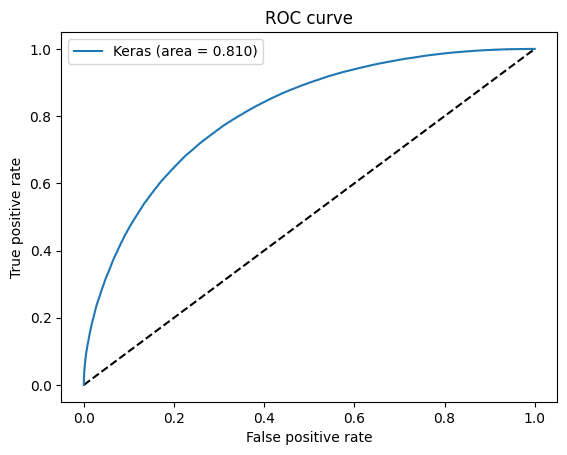

In [16]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, predictions)
auc_keras = auc(fpr_keras, tpr_keras)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig("ROC-AUC_PCA_nojets2and4.png")
plt.show()

Save model, encoder and AUC figure

In [17]:
%cp /content/nojets2and4.h5 /content/gdrive/My\ Drive
%cp /content/ROC-AUC_PCA_nojets2and4.png /content/gdrive/My\ Drive
#%cp /content/encoder_name.h5 /content/gdrive/My\ Drive